![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import BaggingClassifier, VotingClassifier

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

El uso de bicicletas alcanza su maximo valor durante el Otoño, seguido del Verano. Las personas aprovechan las condiciones climaticas mas suaves y agradables presentadas durante estas dos estaciones para usar la bicicleta. La Primavera es la estacion con el promedio mas bajo de alquiler de bicicletas, podriamos inferir que esto se relaciona a condiciones climaticas mas variables o a la presencia de lluvias frecuentes en algunos contextos geograficos. El Invierno, siendo la estacion mas fria, presenta un uso significativo de la bicicleta, lo que podria indicar una buena efectividad en la infraestructura para el uso de la misma o en las medidas de comodidad implementadas por el servicio. 

In [5]:
# Cálculo de métricas adicionales para "season"
bikes.groupby('season')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


- Existe una variabilidad significativa en el uso de bicicletas a lo largo de las estaciones, con el Otoño mostrando el promedio mas alto de alquileres y la Primavera el mas bajo.
- La desviacion estandar elevada en todas las temporadas indica una amplia gama de demanda diaria, reflejando la influencia de factores como el clima, eventos, y dias laborables en contraste con los fines de semana.
- Los percentiles y el rango de alquileres sugieren una distribucion sesgada hacia dias con menos alquileres en todas las estaciones del clima, con algunos dias alcanzando picos significativamente altos de alquiler.
- Las diferencias en el promedio de alquileres entre estaciones resaltan el impacto del clima en la preferencia por el uso de bicicletas compartidas. con aumentos notables en los meses mas calidos y con las mejores condiciones climaticas.

In [6]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

- Entre las horas de la madrugada (0:00 - 4:00) se presenta el menor promedio del uso de la bicicleta, lo cual es esperado debido a una menor actividad durantes estas horas. 
- A partir de las 5:00, hay un incremento considerable, alcanzando su primer pico cerca de las 8:00. Esto debido al gran uso de bicicletas para el desplazamiento hacia el lugar de trabajo. 
- Despues de las 9:00 se nota una leve disminucion en el promedio de uso, y asi se mantiene hasta horas de la tarde. 
- Entre las 17:00 y las 18:00 se observan nuevo picos en el promedio de uso de bicicleta. Inferimos que esto se presenta debido al uso de la misma para el retorno a los hogares. 
- Despues de las 18:00 se observa una disminucion gradual del promedio a medida que avanza la noche.

In [7]:
# Cálculo de métricas adicionales para "hour"
bikes.groupby('hour')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


- La distribucion del uso de bicicletas a lo largo del dia refleja patrones de desplazamientos tipicos de las poblaciones, con picos durante las horas de inicio y final de la jornada laboral.
- La variabilidad en el numero de alquileres es mas alta durante las horas de mayor actividad, lo que sugiere una mayor fluctuacion en cuanto a los alquileres.
- El rango de alquileres es amplio en todas las horas, pero especialmente notable durante las horas pico, reflejando la variabilidad en la demanda diaria y estacional.
- Se tiene un porcentaje bajo de alquileres nocturnos, lo que visualiza una poblacion activa durante la noche.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

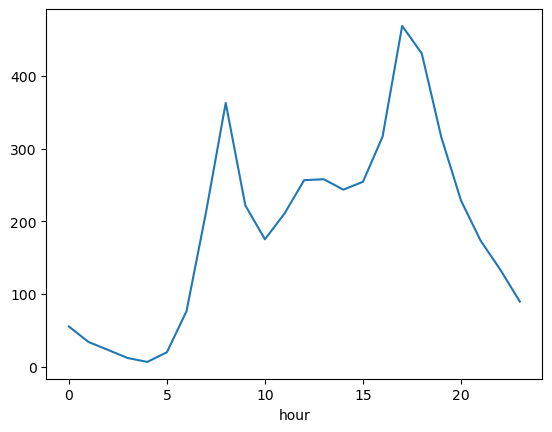

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

- **Horas Tempranas (0-5)**: Hay un uso muy bajo de bicicletas, lo cual es esperable ya que son horas en las que la mayoría de las personas están en casa descansando.

- **Comienzo del Día Laboral (6-9)**: Observamos un fuerte incremento en el alquiler de bicicletas, con un pico notable alrededor de las 8 de la mañana. Este pico puede estar relacionado con las personas que se dirigen a sus lugares de trabajo o estudio.

- **Mitad del Día (10-15)**: Aunque el uso disminuye después de la hora pico de la mañana, sigue habiendo una actividad considerable, probablemente debido a los usuarios que realizan actividades personales, recados o que disfrutan de un tiempo libre al mediodía.

- **Fin del Día Laboral (16-19)**: Existe otro pico prominente entre las 17 y las 18 horas, que es incluso más alto que el de la mañana. Este pico refleja el uso de bicicletas para el viaje de regreso a casa y podría estar asociado también con actividades de ocio al finalizar la jornada laboral.

- **Noche (20-23)**: Después de las 19 horas, el número de alquileres comienza a disminuir considerablemente, aunque sigue siendo más alto que en las primeras horas de la mañana.

<Axes: xlabel='hour'>

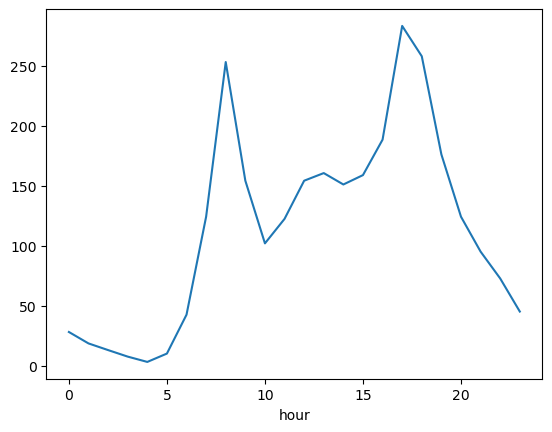

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()

- **Horas de la Madrugada (0-5)**: Hay un uso muy bajo de bicicletas durante las horas de la madrugada, con los valores más bajos a las 4 a.m. Esto es consistente con las expectativas, ya que las temperaturas más frías y la oscuridad son factores que desincentivan el uso de bicicletas.

- **Inicio de la Actividad Matutina (6-9)**: Se observa un aumento significativo a las 6 a.m., seguido por un pico pronunciado alrededor de las 8 a.m. Aunque este pico es notable, es menos marcado en comparación con el pico observado en la gráfica anterior que representaba todas las estaciones. Esto sugiere que, aunque el patrón de desplazamiento sigue presente en invierno, la cantidad de usuarios es menor, posiblemente debido al frío.

- **Mediodía (10-15)**: La actividad se mantiene relativamente constante durante estas horas, pero con niveles más bajos en comparación con el patrón anual. Esto podría ser un indicador de que menos personas eligen usar bicicletas para actividades no esenciales durante el invierno.

- **Horas Pico de la Tarde (16-19)**: Se ve otro aumento en el uso al final de la jornada laboral, con un pico alrededor de las 17-18 horas. Sin embargo, el número de bicicletas alquiladas es significativamente menor que el pico matutino y también menor en comparación con el pico de la tarde en la temporada general.

- **Noche (20-23)**: La gráfica muestra un descenso rápido después de las horas pico de la tarde, con un uso mínimo de bicicletas en la noche, lo cual puede ser aún más pronunciado debido a las temperaturas más bajas y las condiciones climáticas adversas.

<Axes: xlabel='hour'>

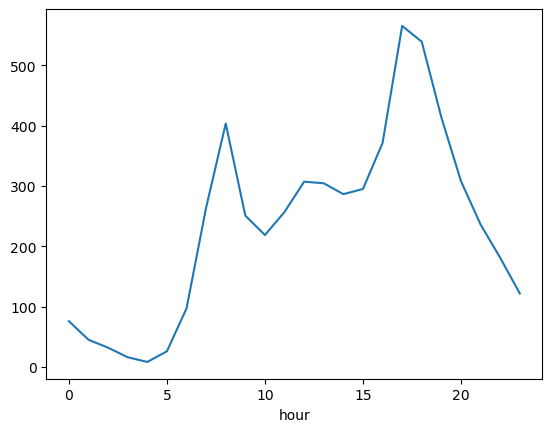

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()

- **Horas de la Madrugada (0-5)**: Al igual que en invierno, el uso es mínimo durante la madrugada, aunque el promedio parece ligeramente superior al observado en la temporada de invierno.

- **Comienzo de la Actividad Matutina (6-9)**: Hay un rápido incremento en los alquileres a partir de las 6 a.m., alcanzando un pico alto alrededor de las 8 a.m. Este pico es notablemente más alto que el de invierno, lo cual es esperable debido al clima más cálido y agradable del verano, lo que favorece el uso de la bicicleta.

- **Mediodía (10-15)**: A diferencia de la temporada de invierno, el uso durante estas horas es bastante significativo, con un pico notable alrededor de las 12-13 horas. Esto podría reflejar una mayor inclinación a actividades recreativas y al uso de la bicicleta para salir a comer o realizar otras actividades en horas de sol.

- **Horas Pico de la Tarde (16-19)**: Se observa un aumento marcado, con el pico más alto del día alrededor de las 17-18 horas, superando los 500 alquileres en promedio. Esto destaca que, en verano, la tendencia al uso de la bicicleta se mantiene fuerte incluso hasta las horas de la tarde.

- **Noche (20-23)**: El uso disminuye después del pico vespertino, pero se mantiene relativamente alto en comparación con la temporada de invierno, lo que puede ser una combinación de temperaturas más cálidas que invitan a actividades nocturnas y días más largos.

La comparación de las gráficas resalta la importancia de considerar las variaciones estacionales y diarias en la gestión de sistemas de bicicletas compartidas y la planificación urbana. Entender estos patrones ayudaría a maximizar la eficiencia operativa y a satisfacer mejor las diferentes necesidades de movilidad de los ciudadanos.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
# Celda 3
season_dummies = pd.get_dummies(bikes['season'], prefix='season', drop_first=True)

bikes['hour'] = pd.to_numeric(bikes['hour'], errors='coerce')

X = pd.concat([season_dummies, bikes['hour']], axis=1)
X = sm.add_constant(X)

y = bikes['total']

X['season_2'] = X['season_2'].astype(int)
X['season_3'] = X['season_3'].astype(int)
X['season_4'] = X['season_4'].astype(int)

model = sm.OLS(y, X).fit()

print(model.summary())

print('Intercepto:', model.params[0])
print('Coeficientes:', model.params[1:])

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     782.5
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:17:34   Log-Likelihood:                -70669.
No. Observations:               10886   AIC:                         1.413e+05
Df Residuals:                   10881   BIC:                         1.414e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4303      4.016     -1.601      0.1

**Interpretacion de Coeficientes:**
- Intercepto (-6.4303): Este es el valor base del número total de alquileres cuando todas las variables predictoras son cero. En este contexto, el intercepto tiene una interpretación limitada porque no tenemos una situación real en la que la temporada sea la categoría de referencia (primavera) y la hora del día sea 0 al mismo tiempo.

- season_2 (100.3172): En promedio, el número total de alquileres durante el verano es aproximadamente 100.32 unidades mayor que en la primavera, asumiendo que todas las demás variables permanecen constantes.

- season_3 (119.4675): En promedio, hay 119.47 alquileres más en otoño en comparación con la primavera, manteniendo constantes el resto de variables.

- season_4 (84.0831): El invierno ve, en promedio, 84.08 alquileres más que la primavera, con las demás variables manteniéndose iguales.

- hour (10.5452): Por cada hora adicional en el día, el número total de alquileres aumenta en promedio por 10.55, lo que refleja una relación lineal positiva entre la hora del día y el número de alquileres.

**¿Cuáles son las limitaciones de la regresión lineal en este caso?**
1. El modelo no considera interacciones entre variables, como cómo el efecto de la hora del día en el número de alquileres podría variar según la temporada.
2. Puede haber factores adicionales que afecten el número total de alquileres, como el clima (temperatura, humedad) y los días festivos o eventos especiales, que no se incluyen en este modelo simple.
3. La variabilidad del número total de alquileres puede cambiar a lo largo del día o entre las estaciones, lo que puede violar la suposición de homocedasticidad de la regresión lineal.
4. Dado que los datos son temporales, es probable que las observaciones no sean independientes entre sí, especialmente en datos recopilados en intervalos de tiempo consecutivos.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [12]:
X = bikes[['season', 'hour']]  # Variables predictoras
y = bikes['total']  # Variable objetivo

In [13]:
def variance_reduction(X_col, y, split):
    # Dividir el conjunto de datos
    y_left = y[X_col < split]
    y_right = y[X_col >= split]
    
    # Calcular la varianza total antes de la división
    var_total = y.var()
    
    # Calcular la varianza ponderada después de la división
    var_left = y_left.var()
    var_right = y_right.var()
    var_weighted = (len(y_left) / len(y)) * var_left + (len(y_right) / len(y)) * var_right
    
    # Calcular la reducción en la varianza
    reduction = var_total - var_weighted
    
    return reduction

In [14]:
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las variables
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = variance_reduction(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [15]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [16]:
# Crear el árbol
tree = tree_grow(X, y, max_depth=6, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 9133.79199674504,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 3594,
  'gain': 3598.6367528160126,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 3139,
   'gain': 322.6431585714513,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [1, 2.0],
    'n_samples': 2684,
    'gain': 191.03245396534635,
    'sl': {'y_pred': 1,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': [0, 2.0],
     'n_samples': 909,
     'gain': 144.93302697484455,
     'sl': {'y_pred': 1,
      'y_prob': 23.32456140350877,
      'level': 5,
      'split': [1, 1.0],
      'n_samples': 226,
      'gain': 20.604845835089236,
      'sl': {'y_pred': 1,
       'y_prob': 27.808695652173913,
       'level': 6,
       'split': -1,
       'n_samples': 113,

In [17]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [18]:
# Ejecución de función tree_predict
tree_predict(X, tree)

array([1., 1., 1., ..., 1., 1., 1.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

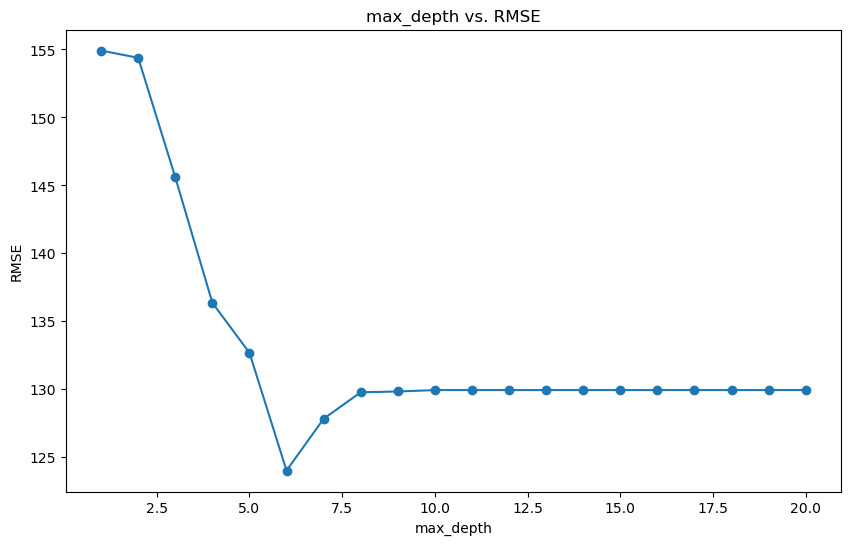

El max_depth óptimo es: 6


In [19]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE o R² para cada valor de máxima profundidad (max_depth)
rmse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la librería sklearn
    reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Uso de cross_val_score para calcular el score. Se utiliza neg_mean_squared_error como scoring para calcular el RMSE
    # y se toma la raíz cuadrada al final porque cross_val_score devuelve negativo MSE para maximizar los scores positivos.
    mse_scores = -cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error').mean()
    rmse_scores.append(np.sqrt(mse_scores))

# Gráfica max_depth versus RMSE (error del modelo)
plt.figure(figsize=(10,6))
plt.plot(max_depth_range, rmse_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('max_depth vs. RMSE')
plt.show()

# Encontrar el max_depth con el menor RMSE
optimal_depth = max_depth_range[rmse_scores.index(min(rmse_scores))]
print(f'El max_depth óptimo es: {optimal_depth}')

In [20]:
# Celda 5

bikes['season'] = bikes['season'].astype(int)
bikes['hour'] = bikes['hour'].astype(int)

# Definir las variables predictoras y la variable objetivo
X = bikes[['season', 'hour']]
y = bikes['total']

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Crear y entrenar el modelo
tree_reg = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
tree_reg.fit(X_train, y_train)


# Predecir sobre el conjunto de validación
y_pred = tree_reg.predict(X_val)

# Calcular métricas de desempeño
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse}, RMSE: {rmse}, R^2: {r2}")

MSE: 13658.691085397999, RMSE: 116.87040294872779, R^2: 0.5861872443644088


El coeficiente de determinación (R²) de 0.5862 con max_depth=6 es mayor que el R² obtenido en el modelo de regresión lineal, lo que indica una mejora en la capacidad del modelo de árbol de decisión para explicar la variabilidad de los datos en comparación con el modelo lineal simple.

El RMSE de 116.870 sugiere que las predicciones del modelo se desvían en promedio aproximadamente 117 unidades del valor real. Comparado con el modelo anterior (sin la optimización de max_depth), este RMSE indica una precisión ligeramente mejor en las predicciones del modelo.

El ajuste del árbol de decisión ha mejorado significativamente el desempeño del modelo, haciendo un mejor trabajo al predecir el total de alquileres de bicicletas basado en "season" y "hour". 

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la noticia es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [21]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [22]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [23]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [24]:
# Celda 6
# Calibración del parámetro 'max_depth'
depth_range = range(1, 10)
best_score = 0
best_depth = 0
for depth in depth_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    score = tree.score(X_test, y_test)
    if score > best_score:
        best_score = score
        best_depth = depth
        
# Entrenando el árbol con la mejor profundidad encontrada
tree_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
tree_best.fit(X_train, y_train)
y_pred_tree = tree_best.predict(X_test)

# Regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Evaluación de los modelos
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_score_tree = f1_score(y_test, y_pred_tree)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_score_log_reg = f1_score(y_test, y_pred_log_reg)

print(f"Árbol de decisión - Mejor profundidad: {best_depth}, Accuracy: {accuracy_tree}, F1-Score: {f1_score_tree}")
print(f"Regresión logística - Accuracy: {accuracy_log_reg}, F1-Score: {f1_score_log_reg}")

Árbol de decisión - Mejor profundidad: 4, Accuracy: 0.6513333333333333, F1-Score: 0.6345213137665969
Regresión logística - Accuracy: 0.6166666666666667, F1-Score: 0.606971975393028


- El Árbol de decisión con una profundidad de 4 capas resultó en un Accuracy de 65.13% y un F1-Score de 63.45%. Esto indica que, en general, el modelo de árbol de decisión ha predicho correctamente el 65.13% de las noticias populares y no populares. El F1-Score, que combina la precisión y la sensibilidad (recall) en una sola métrica, sugiere que el modelo tiene un rendimiento razonablemente equilibrado en términos de precisión y capacidad para recuperar instancias positivas.

- La Regresión logística, por otro lado, resultó en un Accuracy de 61.33% y un F1-Score de 60.22%. Aunque estos resultados son ligeramente inferiores a los del árbol de decisión, aún demuestran una capacidad aceptable del modelo para clasificar correctamente las noticias según su popularidad.

**Mejor Modelo:** Basado en ambas métricas (Accuracy y F1-Score), el modelo de árbol de decisión supera ligeramente al modelo de regresión logística. Podriamos deducir que es debido a que el árbol de decisión puede capturar mejor las relaciones no lineales y las interacciones entre características sin la necesidad de una transformación explícita de características, a diferencia de la regresión logística que asume relaciones lineales entre las variables independientes y la variable dependiente.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [25]:
# Celda 7
# Inicializar listas para guardar modelos y predicciones
models = []
predictions = []

# Crear 100 árboles de decisión con max_depth específico
for _ in range(100):
    model = DecisionTreeClassifier(max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    models.append(model)
    predictions.append(model.predict(X_test))

# Crear 100 árboles de decisión con min_samples_leaf específico
for _ in range(100):
    model = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
    model.fit(X_train, y_train)
    models.append(model)
    predictions.append(model.predict(X_test))

# Crear 100 regresiones logísticas
for _ in range(100):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    models.append(model)
    predictions.append(model.predict(X_test))
# Convertir la lista de predicciones en una matriz de NumPy para facilitar los cálculos
predictions = np.array(predictions)

# Realizar la votación mayoritaria
majority_vote = np.round(predictions.mean(axis=0)).astype(int)

# Evaluar el ensamble
ensemble_accuracy = accuracy_score(y_test, majority_vote)
ensemble_f1 = f1_score(y_test, majority_vote)

print(f"Ensemble - Accuracy: {ensemble_accuracy:.4f}, F1-Score: {ensemble_f1:.4f}")

Ensemble - Accuracy: 0.6333, F1-Score: 0.6223


In [26]:
# Configurar y entrenar los modelos Bagging
models_bagging = {
    "Bagging Max Depth": BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4, random_state=42), n_estimators=100, random_state=42),
    "Bagging Min Samples Leaf": BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=5, random_state=42), n_estimators=100, random_state=42),
    "Bagging Logistic Regression": BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000, random_state=42), n_estimators=100, random_state=42),
}

# Evaluar cada grupo de modelos bagging
for name, model in models_bagging.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

Bagging Max Depth - Accuracy: 0.6460, F1-Score: 0.6419
Bagging Min Samples Leaf - Accuracy: 0.6553, F1-Score: 0.6583
Bagging Logistic Regression - Accuracy: 0.6160, F1-Score: 0.6044


1. **Bagging Tree Max Depth (Árbol de decisión con profundidad máxima calibrada):**
    - Accuracy: 64.60%
    - F1-Score: 64.19%
    
    Este modelo muestra un desempeño sólido, lo que indica que limitar la profundidad del árbol ha ayudado a evitar el sobreajuste y ha mantenido un  buen balance entre precisión y recall.
    
2. **Bagging Tree Min Samples Leaf (Árbol de decisión con mínimo de muestras por hoja calibrado):**

    - Accuracy: 65.53%
    - F1-Score: 65.83%
    
    Este modelo tiene el mejor desempeño tanto en accuracy como en F1-Score entre los modelos individuales, sugiriendo que ajustar el parámetro min_samples_leaf ha contribuido a mejorar la generalización del modelo.
    
3. **Bagging Logistic Regression (Regresión logística):**

    - Accuracy: 61.60%
    - F1-Score: 60.44%

    El desempeño de la regresión logística es el más bajo en comparación con los árboles de decisión, lo cual podría indicar que las relaciones entre las variables y la clasificación no son completamente lineales o que este modelo se beneficia menos del bagging.
    
4. **Voting Ensemble (Ensamble de votación mayoritaria):**

    - Accuracy: 63.33%
    - F1-Score: 62.23%
    
    Curiosamente, el ensamble de votación mayoritaria no superó a todos los modelos individuales en términos de desempeño. Sin embargo, su desempeño está bastante cercano al de los árboles de decisión bagging, demostrando una combinación robusta de las diferentes estrategias de modelado.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [27]:
# Celda 8
# Configuración inicial de modelos
base_models = {
    "tree_max_depth": DecisionTreeClassifier(max_depth=4, random_state=42),
    "tree_min_samples_leaf": DecisionTreeClassifier(min_samples_leaf=5, random_state=42),
    "logistic_regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Recolectar las predicciones de probabilidad para votación ponderada
prob_predictions = []

for name, model in base_models.items():
    bagging_model = BaggingClassifier(base_estimator=model, n_estimators=100, random_state=42, n_jobs=-1)
    bagging_model.fit(X_train, y_train)
    prob_preds = bagging_model.predict_proba(X_test)[:, 1]  # Obtener probabilidades para la clase positiva
    prob_predictions.append(prob_preds)

weights = [0.65, 0.66, 0.62]  # Estos pesos son ejemplos basados en los resultados de Accuracy del punto anterior

# Calcular las predicciones ponderadas
weighted_probs = np.average(prob_predictions, axis=0, weights=weights)

# Convertir probabilidades ponderadas a clases predichas basándose en un umbral (p.ej., 0.5)
final_preds_weighted = np.where(weighted_probs > 0.5, 1, 0)

# Evaluar el ensamble ponderado
ensemble_accuracy_weighted = accuracy_score(y_test, final_preds_weighted)
ensemble_f1_weighted = f1_score(y_test, final_preds_weighted)

print(f"Ensemble Weighted Voting - Accuracy: {ensemble_accuracy_weighted:.4f}, F1-Score: {ensemble_f1_weighted:.4f}")

Ensemble Weighted Voting - Accuracy: 0.6480, F1-Score: 0.6475


Los resultados obtenidos con el ensamble de votación ponderada muestran una mejora en comparación con los modelos individuales y el ensamble de votación mayoritaria que discutimos anteriormente:

- Accuracy: 64.80%
- F1-Score: 64.75%

La ligera mejora en el desempeño, tanto en términos de Accuracy como de F1-Score, indica que la ponderación basada en el desempeño de los modelos individuales puede ser una estrategia efectiva para mejorar la precisión de las predicciones en ejercicios de clasificación. Este resultado es de revelancia porque indica que los modelos individuales, al ser combinados de manera estratégica, pueden complementar sus respectivas fortalezas y debilidades para lograr un mejor rendimiento general.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

**Resultados Obtenidos**

Los resultados mostraron que los **modelos de árboles de decisión bagged superaron a la regresión logística bagged**, tanto individualmente como en los ensambles. Entre los árboles de decisión, el que ajustaba el **min_samples_leaf** resultó ser ligeramente superior en desempeño que los demas.

El **ensamble de votación mayoritaria** produjo un rendimiento que fue cercano pero no superior al mejor modelo bagged individual (árbol de decisión con **min_samples_leaf**). Por otro lado, el **ensamble de votación ponderada** mostró una ligera mejora en comparación con el ensamble de votación mayoritaria y fue ligeramente superior al mejor modelo individual.

**Comparación y Análisis**

- Flexibilidad y Robustez: Los ensambles, tanto de votación mayoritaria como ponderada, ofrecen una mayor flexibilidad y robustez en comparación con los modelos individuales. Al combinar diferentes modelos, los ensambles pueden aprovechar sus respectivas fortalezas y mitigar sus debilidades.

- Desempeño: La votación ponderada mostró un desempeño ligeramente superior, lo cual indica que asignar más peso a los modelos con mejor desempeño puede ser una estrategia efectiva. Sin embargo, la mejora no fue significativa, sugiriendo que todos los modelos individuales ya tenían desempeños relativamente buenos y equilibrados.

- Complejidad y Costo Computacional: Implementar ensambles, especialmente con métodos de bagging y votación ponderada, puede aumentar la complejidad y el costo computacional. Aunque este enfoque mejoró el desempeño, la mejora debe ser evaluada en el contexto del costo adicional en tiempo de entrenamiento y recursos.

- Interpretabilidad: Los modelos individuales, especialmente los árboles de decisión, tienden a ser más interpretables que los ensambles. A medida que agregamos capas de ensamblaje, sacrificamos cierta interpretabilidad por un aumento en el desempeño.

**Ventajas y Desventajas**

1. Votación Mayoritaria:

    - Ventajas: Simplicidad en la implementación y decisiones basadas en la mayoría que pueden ser efectivas cuando los modelos tienen desempeños similares.
    - Desventajas: No distingue entre los modelos con diferentes niveles de desempeño.

2. Votación Ponderada:

    - Ventajas: Permite diferenciar entre modelos basados en su eficacia, potencialmente llevando a mejores decisiones de ensamble.
    - Desventajas: Requiere una calibración adicional para determinar los pesos adecuados, lo cual puede ser complejo y dependiente del conjunto de datos.
    

Ambas metodologías de ensamble presentan una estrategia válida para mejorar el desempeño de modelos de clasificación.La votación ponderada parece ofrecer una ventaja cuando hay una variación significativa en el desempeño de los modelos individuales, mientras que la votación mayoritaria puede ser suficiente y más fácil de implementar cuando los modelos son uniformemente efectivos.